# Creates PDBBind databases

This code turn PDBBind datasets into an icosahedron projection form. We're using only the binding sites. The core set contains only about 150 proteins. 

Here goes!

(This is based on the hacky proof of principle data used in the RSC AIChem conference in Sept 2020)

Updated in Jan 2021 - no longer hacky

After running this you will have to run the normalisation script.

#### Settings to change
Change this to point the `data_dir` at where you've downloaded the PDB_Bind files. `save_dir` is created, change this to where you want the output files to be put. You can use `deepchem` to grab the datasets for you, or download them from the site directly. Pick one of the PDBCodes as a test case

In [6]:
save_dir=r'F:\Nextcloud\science\Datasets\converted_pdbbind\v2015'
data_dir=r'F:\Nextcloud\science\Datasets\pdbbind\v2015'
test_file='1a1c_pocket.pdb'
test_file_ligand='1a1c_ligand.mol2'
test_pdb_code='1a1c'

#### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot
import matplotlib.tri 
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import mpl_toolkits.mplot3d
import operator
import functools
import os
import gif
import h5py
import scipy.linalg
import slugify
import sys
import random

from skspatial.objects import Point, Vector, Triangle
from operator import attrgetter
from scipy.constants import golden
from IPython.display import HTML

import projection
from projection.molecule import Molecule
from projection.pdbmolecule import PDBMolecule
from projection.mol2molecule import Mol2Molecule
from projection.face import Face

from projection.ico import Ico
verbose=False

#### TEST that Molecule and Ico have been found 

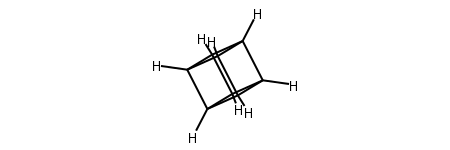

In [3]:
# everyone loves cubane
m=Molecule('C12C3C4C1C5C2C3C45')
m.molecule

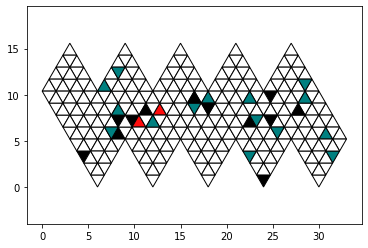

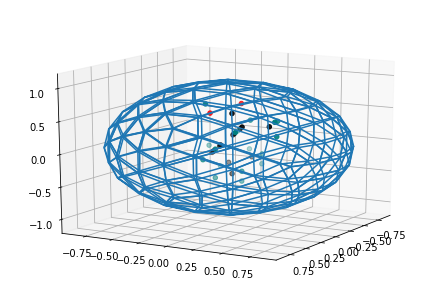

In [4]:
# this should produce a map and a molecule in a (squashed) sphere
m=Molecule('CC(C)Cc1ccc(cc1)C(C)C(=O)O')
i = Ico(m,2)
i.draw2D()
i.draw3D()

#### TEST that we can load the pdb files and do stuff with them

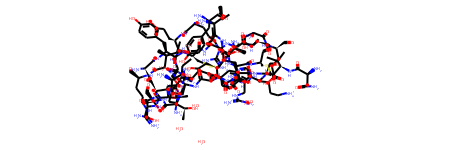

In [5]:
# this should produce a picture of the binding pocket 
# this uses rdkit and gets the original (non-zero centred) positions
test_file_location=os.path.join(data_dir, test_pdb_code, test_file)
mol_orig=rdkit.Chem.rdmolfiles.MolFromPDBFile(test_file_location)
mol_orig

In [6]:
# checks that the coords are around 0 
egg=mol_orig.GetConformer()
rdkit.Chem.rdMolTransforms.CanonicalizeConformer(egg)

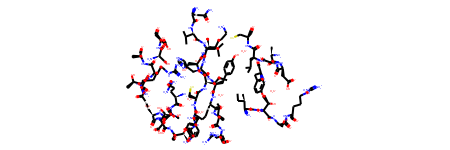

In [7]:
# this uses my code to grab and load the samebinding pocket
mol=PDBMolecule(test_file_location)
mol.molecule

In [8]:
# this should give the coords of the first 9 atoms, 
# expect them to be 0.0 centred
mol.coords[:9]

array([[-0.42794441, -0.05791095,  0.20604107],
       [-0.44931031, -0.01307296,  0.18173734],
       [-0.43814742, -0.01406735,  0.12447671],
       [-0.40149876, -0.03731045,  0.10902197],
       [-0.42597904,  0.03431996,  0.20841898],
       [-0.36827808,  0.03833703,  0.20468507],
       [-0.44068736,  0.02932603,  0.26529773],
       [-0.34637913,  0.08579796,  0.22909843],
       [-0.46655245,  0.01281388,  0.09271203]])

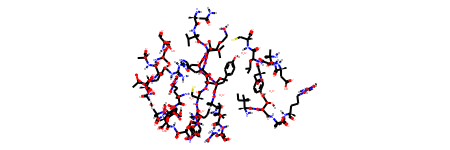

In [9]:
# this uses my code to grab and load the samebinding pocket
mol2=PDBMolecule(test_file_location,
                sanitize=False,
                do_random_rotation=True, 
                rotation_vector=[0,0,90])
mol2.molecule

In [10]:
# this should give the coords of the first 9 atoms, 
# expect them to be 0.0 centred
mol2.coords[:9]

array([[ 0.05647411, -0.41733149,  0.20093129],
       [ 0.05295553, -0.38575496,  0.22273729],
       [ 0.01274806, -0.43816749,  0.17723028],
       [ 0.01371781, -0.42728144,  0.12138971],
       [ 0.03638454, -0.39154168,  0.10631824],
       [-0.03346949, -0.41541479,  0.20325021],
       [-0.03738684, -0.3591448 ,  0.1996089 ],
       [-0.02859943, -0.42975835,  0.25871838],
       [-0.08367072, -0.33778891,  0.22341681]])

#### TEST that the pdb file imported using my code can be projected

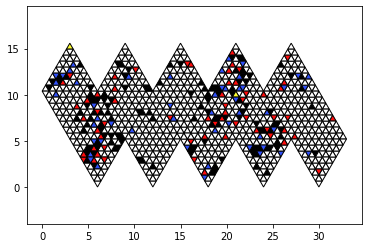

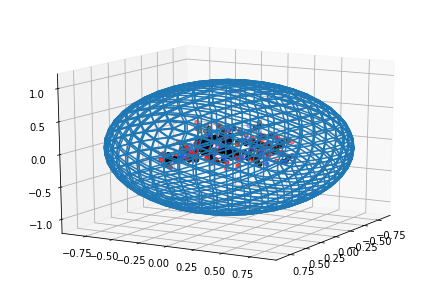

In [11]:
m=mol
ico = Ico(m,3)
ico.draw2D()
ico.draw3D()

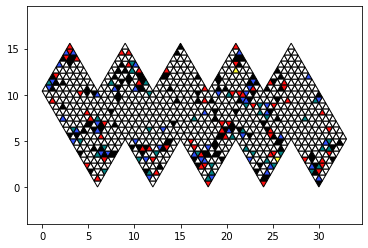

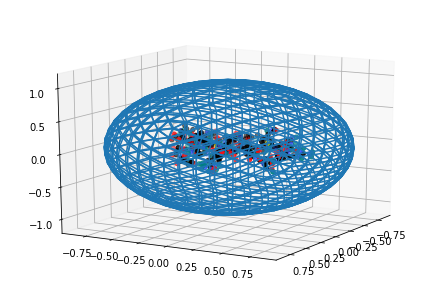

In [12]:
m=mol2
ico = Ico(m,3)
ico.draw2D()
ico.draw3D()

#### TEST that we can load the ligand mol2 files and do stuff with them

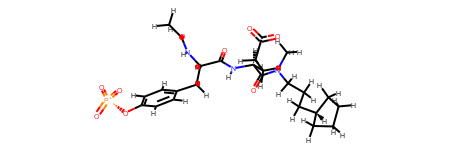

In [13]:
# test with icosahedron project code
# you should see a molecule
test_file_location=os.path.join(data_dir, test_pdb_code, test_file_ligand)
lig=Mol2Molecule(test_file_location,
                 sanitize=False)
lig.molecule

In [14]:
lig.coords[:9]

array([[-0.29981826,  0.28726747, -0.18220105],
       [-0.28049668,  0.39553994, -0.08881311],
       [-0.39032181,  0.30366824, -0.07104095],
       [-0.22548967,  0.14363359, -0.15909464],
       [-0.14352878,  0.07074499,  0.05018064],
       [-0.09109284, -0.08960892, -0.05666585],
       [-0.14290352, -0.02397338, -0.17424766],
       [-0.33320793, -0.02258726, -0.2072565 ],
       [-0.21544977, -0.1235974 ,  0.09739578]])

#### TEST that you can create a projection of the ligand

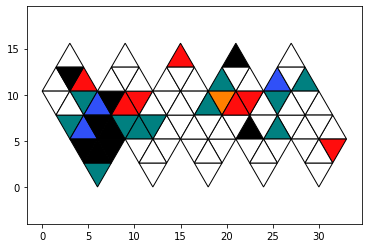

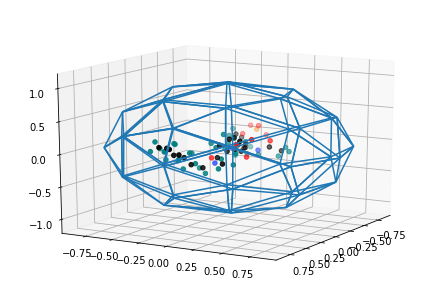

In [15]:
m=lig
ico = Ico(m,1)
ico.draw2D()
ico.draw3D()

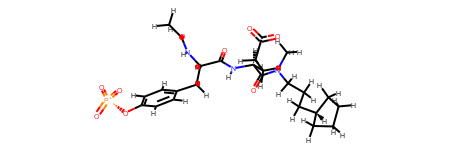

In [16]:
# this uses my code to grab and load the samebinding pocket

test_file_location=os.path.join(data_dir, test_pdb_code, test_file_ligand)
lig2=Mol2Molecule(test_file_location,
                 sanitize=False,
                 do_random_rotation=True, 
                 rotation_vector=[180,90,45])
lig2.molecule

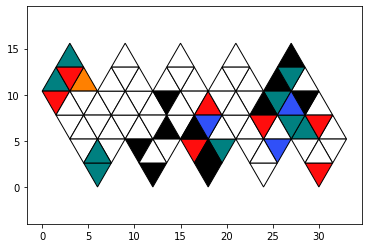

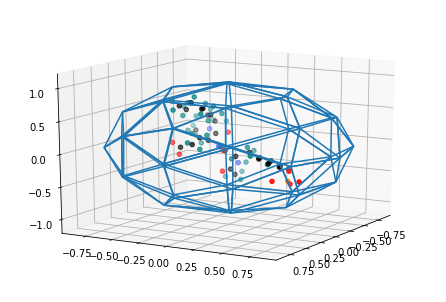

In [17]:
m=lig2
ico = Ico(m,1)
ico.draw2D()
ico.draw3D()

In [18]:
# this should give the coords of the first 9 atoms, 
# expect them to be 0.0 centred
lig2.coords[:9]

array([[-0.19319614,  0.00941031, -0.44018382],
       [-0.09417262, -0.08625688, -0.50687723],
       [-0.07532798,  0.06497091, -0.52033831],
       [-0.16869535,  0.06137387, -0.27676042],
       [ 0.05320883,  0.05457167, -0.16065771],
       [-0.06008541,  0.13548617, -0.00111261],
       [-0.18476279,  0.12512059, -0.08917118],
       [-0.21976357,  0.26676732, -0.23289647],
       [ 0.10327321,  0.25421003, -0.06886887]])

scale = np.array(_points).flatten('K')
figure = matplotlib.pyplot.figure()
axes = mpl_toolkits.mplot3d.Axes3D(figure)
mesh = i.get_mesh()

def draw(a,b):
    # Load the stuff
    m.draw3D(axes)
    axes.add_collection3d(mpl_toolkits.mplot3d.art3d.Line3DCollection(mesh))
    axes.auto_scale_xyz(scale, scale, scale*1.25)
    axes.view_init(a,b) 
    matplotlib.pyplot.draw()

#m.draw3D(axes)
#draw(12,15)
    
def frame(i):
    draw(20,i)
from matplotlib import animation, rc
video=animation.FuncAnimation(figure, frame,frames=360, interval=20).to_html5_video()
HTML(video)

# Making the datasets

## Read in the code data as dataframes
This section reads the information, including the target information, for each file and gets the lists of which protein-ligand combo is in which dataset. 
The datasets are:
1. `core` which is the test or generalisation dataset
2. `refined` which is the larger training dataset

The files are:
1. `INDEX` which links codes to the protein name and EC number
2. `DATA` which links the codes to the binding constant (target)

In [19]:
data_dir

'F:\\Nextcloud\\science\\Datasets\\pdbbind\\v2015'

In [20]:
## This reads in the pdb codes for each protein in the core dataset
fh = open(os.path.join(data_dir, "INDEX_core_name.2013"),'r')
c = 0
column_list_name=["PDB_code", "release_year", "EC_number", "protein_name"]
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            last_word = words[3:]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
            new_line=[words[0],words[1],words[2], last_word]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_index_core = pd.DataFrame(lines, columns=column_list_name)

In [21]:
## This reads in the pdb codes for each protein in the refined dataset
fh = open(os.path.join(data_dir, "INDEX_refined_name.2015"),'r')
c = 0
column_list_name=["PDB_code", "release_year", "EC_number", "protein_name"]
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            last_word = words[3:]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
            new_line=[words[0],words[1],words[2], last_word]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_index_refined = pd.DataFrame(lines, columns=column_list_name)

#### TEST that the index files was read correctly

In [22]:
df_index_refined.head()

,PDB_code,release_year,EC_number,protein_name
0,1i1e,2001,E.C.3.4.24.69,BOTULINUM_NEUROTOXIN_TYPE_B
1,1bxr,1999,E.C.6.3.5.5,CARBAMOYL-PHOSPHATE_SYNTHASE
2,3i3b,2010,E.C.3.2.1.23,BETA-GALACTOSIDASE
3,3dyo,2008,E.C.3.2.1.23,BETA-GALACTOSIDASE
4,3t0d,2012,E.C.3.2.1.23,BETA-GALACTOSIDASE


In [23]:
## This reads in the data for each protein core dataset
## the y values is the -logKd/Ki
fh = open(os.path.join(data_dir, "INDEX_core_data.2013"),'r')
c = 0
column_list_data=["PDB_code", 
             "resolution", 
             "release_year", 
             "-logKd/Ki", 
             "Kd/Ki", 
             "reference",
             "ligand name"]
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            # Not actually the last word!
            last_word = words[5:-1]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
    
            new_line=[words[0],words[1],words[2],words[3],words[4], last_word, words[-1][1:-2]]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_data_core = pd.DataFrame(lines, columns=column_list_data)
df_data_core.head()

,PDB_code,resolution,release_year,-logKd/Ki,Kd/Ki,reference,ligand name
0,3ao4,1.95,2011,2.07,Kd=8.5mM,//_3ao1.pdf,833
1,3i3b,2.20,2010,2.23,Ki=5.9mM,//_3i3b.pdf,149
2,1uto,1.15,2004,2.27,Kd=5.32mM,//_1uto.pdf,PEA
3,1ps3,1.80,2003,2.28,Ki=5.2mM,//_1ps3.pdf,KIF
4,1qi0,2.10,2000,2.35,Ki=4.5mM,//_1qi0.pdf,CBI


In [24]:
## This reads in the data for each protein refined dataset
## the y values is the -logKd/Ki
fh = open(os.path.join(data_dir, "INDEX_refined_data.2015"),'r')
c = 0
column_list_data=["PDB_code", 
             "resolution", 
             "release_year", 
             "-logKd/Ki", 
             "Kd/Ki", 
             "reference",
             "ligand name"]
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            # Not actually the last word!
            last_word = words[5:-1]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
    
            new_line=[words[0],words[1],words[2],words[3],words[4], last_word, words[-1][1:-2]]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_data_refined = pd.DataFrame(lines, columns=column_list_data)
df_data_refined.head()

,PDB_code,resolution,release_year,-logKd/Ki,Kd/Ki,reference,ligand name
0,2r58,2.00,2007,2.00,Kd=10mM,//_2r58.pdf,MLY
1,3c2f,2.35,2008,2.00,Kd=10.1mM,//_3c2f.pdf,PRP
2,3g2y,1.31,2009,2.00,Ki=10mM,//_3g2y.pdf,GF4
3,3pce,2.06,1998,2.00,Ki=10mM,//_3pce.pdf,3HP
4,4qsu,1.90,2014,2.00,Kd=10mM,//_4qsu.pdf,TDR


In [25]:
## This reads in the cluster data for each protein in the core dataset
## the y values is the -logKd/Ki
fh = open(os.path.join(data_dir, "INDEX_core_cluster.2013"),'r')
c = 0
column_list_cluster=['PDB_code', 
             'resolution', 
             'release_year', 
             '-logKd/Ki', 
             'original_Kd/Ki', 
             'cluster ID']
lines=[]
for line in fh.readlines():
    if not line.startswith('#'):
        if c ==0:
            words=[ x for x in line.split(' ') if not x == '']
            last_word = words[5:]
            last_word[-1] = last_word[-1].strip()
            last_word = '_'.join(last_word)
            new_line=[words[0],words[1],words[2],words[3],words[4], last_word]
            #print(new_line)
            lines.append(new_line)
            #df_line = pd.DataFrame([new_line],columns=column_list)
            #print(df_line)
            #df_index_core.append(df_line)
            #labels = line

fh.close()
df_cluster_core = pd.DataFrame(lines, columns=column_list_cluster)
df_cluster_core.head()

,PDB_code,resolution,release_year,-logKd/Ki,original_Kd/Ki,cluster ID
0,1ps3,1.80,2003,2.28,Ki=5.2mM,3_<
1,3d4z,1.39,2008,4.89,Ki=13uM,3_<
2,3ejr,1.27,2009,8.57,Ki=2.7nM,3_<
3,2qmj,1.90,2008,4.21,Ki=62uM,9_<
4,3l4w,2.00,2010,6.00,Ki=1.0uM,9_<


#### TEST that there is no overlap between the core and refined datasets
If this does not give `[]` you have a problem!!! 
Probably you didn't take the data from deepchem, so you'll have to make the sets disjoint yourself.

In [27]:
# there is no overlap!
[x for x in df_index_core['PDB_code'] if x in df_index_refined['PDB_code']]

[]

In [28]:
# there is no overlap!
[x for x in df_data_core['PDB_code'] if x in df_data_refined['PDB_code']]

[]

## Functions to build the datasets

*This is the most important part of the file!*

In [1]:
# Function to build the hdf5 file for the datasets
# Looooooooong function! It's self-documented code , ah ahahahahahaha!
# Here we are reminded that python started off as a scripting language
# This is a script really, not a function
def Create_PDBBind_Dataset(df_cluster, 
                   df_index, 
                   df_data, 
                   DIVISION, 
                   save_dir, 
                   data_dir, 
                   out_filename, 
                   ico_key_name,
                   PDB_or_mol2,
                   do_Hdonors,
                   input_file_end_name='pocket',
                   num_of_proteins_override=0,
                   NUM_MAPS_PER_MOLECULE=60,
                   sanitize=False,
                   SMILES_array=[],
                   num_out_files=1,
                   extra_augmentation='con-rotation',
                   do_cluster=False,
                   verbose=False):
    """ Creates the dataset as a hdf5 file, expects DeepChem PDBBind organised files
    df_cluster = df_cluster_core = df of the cluster data (see the files that DeepChem downloads)
    df_index = df_index_core = df of index data
    df_data = df_data_core = df of the data 
    NUM_MAPS_PER_MOLECULE # how many maps to create
    DIVISION =4 # for the size of icospehre  
    save_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\converted_pdbbind\\v2015'
    data_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\pdbbind\\v2015'
    out_filename = "PDBBindLigands_core_augmented_withHs_withHdonors_div4.hdf5"
    ico_key_name_name = "icosahedron_level4"
    PDB_or_mol2 : 'pdb', 'mol2'
        :whether files are pdb or mol2 obviously
    input_file_end_name: 'ligand', 'protein', 'pocket'
        :whether files are binding pocket only or whole protein or ligand
    num_of_proteins_override : whether to do only a subset of the list
        : set to 0 to do the entire dataset, else set to how many you want
        : these are just the first ones, not shuffled
    do_Hdonors = True/False, whether to do the H donor data or not, don't do it for proteins
    sanitize = False: wehther to let DeepChem sanitize your molecule (NOT RECOMMENDED!)
    SMILES_array: array of smiles strings if you have them: notcurrently tested
    """
        
    if num_of_proteins_override == 0:
        # do all proteins woo
        Num_of_proteins= len(df_index['PDB_code'])
    else:
        Num_of_proteins = num_of_proteins_override
        
    print(f'Doing {Num_of_proteins} molecules')
        
    smile_count = Num_of_proteins # number of things to do
    smiles_count = len(SMILES_array) # num of smiles strings to add in
    pdb_list=df_index['PDB_code']

    if DIVISION == 1:
        NUM_FACES = 80
    elif DIVISION == 2:
        NUM_FACES = 320
    elif DIVISION == 3:
        NUM_FACES = 1280
    elif DIVISION == 4:
        NUM_FACES = 5120
        
    if NUM_MAPS_PER_MOLECULE == 1:
        NUM_UNWRAPPINGS_TO_DO = 1
        NUM_DIRECTIONS_TO_DO = 1
        NUM_EXTRA_MAPS_PER_MOLECULE = 0
    elif NUM_MAPS_PER_MOLECULE == 60:
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
        NUM_EXTRA_MAPS_PER_MOLECULE = 0
    elif NUM_MAPS_PER_MOLECULE > 60:
        # Currently assumes you want 60 plus extra
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
        NUM_EXTRA_MAPS_PER_MOLECULE = NUM_MAPS_PER_MOLECULE-60
        if verbose:
            print('Doing {} extra maps using {}s'.format(
                NUM_EXTRA_MAPS_PER_MOLECULE, 
                extra_augmentation))  
    
    if sanitize:
        print('Warning! Sanitize seems to muck up the structures, especially for protiens')
        print('Think very carefully about if you want to do this, maybe do some testing in deepchem?')
        
    outfile = h5py.File(os.path.join(save_dir,out_filename),"w")
    icosahedron_name = ico_key_name
    string_type = h5py.string_dtype(encoding='utf-8')
    
    if NUM_EXTRA_MAPS_PER_MOLECULE > 0:
        if extra_augmentation == 'conformer':
            print('Doing conformer rotations only, N.B. this only works with SMILES strings')
        elif extra_augmentation == 'con-rotation':
            print('Doing conformers with random rotation')

    ##################### set up the output datasets ################################

    ## this sets up the output datasets
    icosahedron_ds =  outfile.create_dataset(icosahedron_name, (smile_count*NUM_MAPS_PER_MOLECULE, NUM_FACES, 3))  
    molID_ds = outfile.create_dataset("molID", (smile_count*NUM_MAPS_PER_MOLECULE,))
    if smiles_count > 0:
        smiles_ds = outfile.create_dataset("SMILES_strings", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_atoms_ds = outfile.create_dataset("num_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_bonds_ds = outfile.create_dataset("num_bonds", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heavy_atoms_ds = outfile.create_dataset("num_heavy_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_exact_Mol_Wt_ds = outfile.create_dataset("num_exact_Mol_Wt", (smile_count*NUM_MAPS_PER_MOLECULE,))
    MolLogP_ds = outfile.create_dataset("MolLogP", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    if do_Hdonors:
        num_H_acceptors_ds = outfile.create_dataset("num_H_acceptors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
        num_H_donors_ds = outfile.create_dataset("num_H_donors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heteroatoms_ds = outfile.create_dataset("num_ heteroatoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_valence_electrons_ds = outfile.create_dataset("num_valence_electrons", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_1_ds = outfile.create_dataset("PMI_1", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_2_ds = outfile.create_dataset("PMI_2", (smile_count*NUM_MAPS_PER_MOLECULE,))
    PMI_3_ds = outfile.create_dataset("PMI_3", (smile_count*NUM_MAPS_PER_MOLECULE,))
    spherocity_ds = outfile.create_dataset("spherocity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    asphericity_ds = outfile.create_dataset("asphericity", (smile_count*NUM_MAPS_PER_MOLECULE,))
    eccentricity_ds = outfile.create_dataset("eccentricity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    inertial_shape_factor_ds = outfile.create_dataset("inertial_shape_factor", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    radius_of_gyration_ds = outfile.create_dataset("radius_of_gyration", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    # copied from output of df_maker above sigh
    pdb_code_ds = outfile.create_dataset('PDB_code', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    release_year_ds = outfile.create_dataset('release_year', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    ec_number_ds = outfile.create_dataset('EC_number', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    protein_name_ds = outfile.create_dataset('protein_name', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    logkd_ki_ds = outfile.create_dataset('-logKd_over_Ki', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=np.float32)
    kd_ki_ds = outfile.create_dataset('Kd_over_Ki', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    reference_ds = outfile.create_dataset('reference', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    if do_cluster:
        cluster_id_ds = outfile.create_dataset('cluster ID', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    resolution_ds = outfile.create_dataset('resolution', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=np.float32)
    ligand_ds = outfile.create_dataset('ligand_name', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)

    ######################### start the loop ###################################
    
    ## Das Loop##
    point_ptr = -1                                               
    for mol_idx in range(Num_of_proteins): 
        if mol_idx % 50 == 0:
            print('Got to Molecule no. ', mol_idx)
        # finds the pdb file and reads in the molecule
        file_location=os.path.join(data_dir, 
                                   pdb_list[mol_idx], 
                                   pdb_list[mol_idx] + '_' + input_file_end_name + '.' + PDB_or_mol2)
        if verbose:
            print(file_location)
        ##### grab a molecule! #####################################
        if PDB_or_mol2 == 'pdb':
            # doing da protein
            m=PDBMolecule(file_location,
                          sanitize=sanitize,
                          do_random_rotation=False, 
                          rotation_vector=[])
            tidy_m = m
        elif PDB_or_mol2 == 'mol2':
            m=Mol2Molecule(file_location,
                           sanitize=sanitize,
                           do_random_rotation=False, 
                           rotation_vector=[])
            tidy_m = m
            tidy_m.molecule.UpdatePropertyCache() # sigh we had to do this to get H donors!
        elif PDB_or_mol2 == 'smiles':
            m=Molecule(SMILES_array[mol_idx])
            tidy_m = m
            if mol_idx == 1:
                print('Warning: Depreciated, use SMILES dataset creating code not this')
                print('See Create_Delaney_Dataset...')
        else:
            print('Error: file input must be pdb or mol2 or pdb')
            return 0
        ############### put molecule in an icosasphere #############          
        # puts the molecule into an icosasphere
        i = Ico(m,DIVISION)
        print(pdb_list[mol_idx])
        if smiles_count > 0:
            smiles_string = SMILES_array[mol_idx]
        #############################################################################################
        ################################### THIS IS THE FIRST 60 NETS ###############################
        #############################################################################################
        for face_idx in range(NUM_UNWRAPPINGS_TO_DO): 
            for point_idx in range(NUM_DIRECTIONS_TO_DO): 
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### grab the atom values or colours or whatever
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                ################ create the measurables you want to record #############
                values_as_array = np.array(values)
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)
                
                ############ assign measurabless to columns ##########################
                icosahedron_ds[point_ptr] = values_as_array
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                if smiles_count > 0:
                    smiles_ds[point_ptr] = smiles_string
                ######## assign stuff you calculated ######
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 
                ###### assign stuff from the databases
                # get the current PDB code
                current_code=df_index[["PDB_code"]].iloc[[mol_idx]]
                current_code=current_code.iloc[0]['PDB_code']
                # get the rows in the dataframes
                current_index_row=df_index.loc[df_index['PDB_code']==current_code]
                #print(current_code)
                current_data_row=df_data.loc[df_data['PDB_code']==current_code]
                if do_cluster:
                    current_cluster_row=df_cluster.loc[df_cluster['PDB_code']==current_code]
                pdb_code = current_index_row.iloc[0]['PDB_code']
                pdb_code_ds[point_ptr] = np.array(pdb_code,dtype=string_type)
                release_year = current_index_row.iloc[0]['release_year']
                #print(type(release_year))
                release_year_ds[point_ptr] = release_year
                ec_number = current_index_row.iloc[0]['EC_number']
                ec_number_ds[point_ptr] = ec_number
                protein_name = current_index_row.iloc[0]['protein_name']
                protein_name_ds[point_ptr] = protein_name
                logkd_ki = current_data_row.iloc[0]['-logKd/Ki']
                logkd_ki_ds[point_ptr] = float(logkd_ki)
                kd_ki = current_data_row.iloc[0]['Kd/Ki']
                kd_ki_ds[point_ptr] = kd_ki
                reference = current_data_row.iloc[0]['reference']
                reference_ds[point_ptr] = reference
                if do_cluster:
                    cluster_id = current_cluster_row.iloc[0]['cluster ID']
                    cluster_id_ds[point_ptr] = cluster_id
                resolution = current_data_row.iloc[0]['resolution']
                resolution_ds[point_ptr] = float(resolution)
                ligand_name = current_data_row.iloc[0]['ligand name']
                ligand_ds[point_ptr] = ligand_name
        if verbose:
            print('Finished the 60 standard unfoldings')
            #############################################################################################
            ######################## THE EXTRA AUGMENTATION STARTS HERE !################################
            #############################################################################################
        for extra_idx in range(NUM_EXTRA_MAPS_PER_MOLECULE):
            ## this is it, regen the molecule each time you unw
            ## n.b. I think from pdb and mol2 files you don't get different 
            ## conformers each time...
            if extra_augmentation == 'conformer':
                do_random_rotation_here = False
            elif extra_augmentation == 'con-rotation':
                do_random_rotation_here = True
             ##### grab a molecule! #####################################
            if PDB_or_mol2 == 'pdb':
                # doing da protein
                m=PDBMolecule(file_location,
                              sanitize=sanitize,
                              do_random_rotation=do_random_rotation_here, 
                              rotation_vector=[])
                tidy_m = m
            elif PDB_or_mol2 == 'mol2':
                m=Mol2Molecule(file_location,
                               sanitize=sanitize,
                               do_random_rotation=do_random_rotation_here, 
                               rotation_vector=[])
                tidy_m = m
                tidy_m.molecule.UpdatePropertyCache() # sigh we had to do this to get H donors!
            elif PDB_or_mol2 == 'smiles':
                m=Molecule(SMILES_array[mol_idx])
                tidy_m = m
                if mol_idx == 1:
                    print('Warning: Depreciated, use SMILES dataset creating code not this')
                    print('See Create_Delaney_Dataset...')
            else:
                print('Error: file input must be pdb or mol2 or pdb')
                return 0
            ############### put molecule in an icosasphere #############          
            # puts the molecule into an icosasphere
            i = Ico(m,DIVISION)
            #print('New conformer')
            #print(pdb_list[mol_idx])
            if smiles_count > 0:
                smiles_string = SMILES_array[mol_idx]
        #############################################################################################
        ################################### THE EXTRA AUGMENTATION STARTS HERE ###############################
        #############################################################################################        
            for point_idx in range(1): # to avoid indenting
                # we pick the face and direction randomly for this single unfolding
                face_idx = random.choices([x for x in range(NUM_UNWRAPPINGS_TO_DO)], k=1)[0]
                point_idx = random.choices([x for x in range(NUM_DIRECTIONS_TO_DO)], k=1)[0]
                if verbose:
                    print('Doing extra: face {}, direction {}'.format(face_idx, point_idx))
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### grab the atom values or colours or whatever
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                ################ create the measurables you want to record #############
                values_as_array = np.array(values)
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)
                
                ############ assign measurabless to columns ##########################
                icosahedron_ds[point_ptr] = values_as_array
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                if smiles_count > 0:
                    smiles_ds[point_ptr] = smiles_string
                ######## assign stuff you calculated ######
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 
                ###### assign stuff from the databases
                # get the current PDB code
                current_code=df_index[["PDB_code"]].iloc[[mol_idx]]
                current_code=current_code.iloc[0]['PDB_code']
                # get the rows in the dataframes
                current_index_row=df_index.loc[df_index['PDB_code']==current_code]
                #print(current_code)
                current_data_row=df_data.loc[df_data['PDB_code']==current_code]
                if do_cluster:
                    current_cluster_row=df_cluster.loc[df_cluster['PDB_code']==current_code]
                pdb_code = current_index_row.iloc[0]['PDB_code']
                pdb_code_ds[point_ptr] = np.array(pdb_code,dtype=string_type)
                release_year = current_index_row.iloc[0]['release_year']
                #print(type(release_year))
                release_year_ds[point_ptr] = release_year
                ec_number = current_index_row.iloc[0]['EC_number']
                ec_number_ds[point_ptr] = ec_number
                protein_name = current_index_row.iloc[0]['protein_name']
                protein_name_ds[point_ptr] = protein_name
                logkd_ki = current_data_row.iloc[0]['-logKd/Ki']
                logkd_ki_ds[point_ptr] = float(logkd_ki)
                kd_ki = current_data_row.iloc[0]['Kd/Ki']
                kd_ki_ds[point_ptr] = kd_ki
                reference = current_data_row.iloc[0]['reference']
                reference_ds[point_ptr] = reference
                if do_cluster:
                    cluster_id = current_cluster_row.iloc[0]['cluster ID']
                    cluster_id_ds[point_ptr] = cluster_id
                resolution = current_data_row.iloc[0]['resolution']
                resolution_ds[point_ptr] = float(resolution)
                ligand_name = current_data_row.iloc[0]['ligand name']
                ligand_ds[point_ptr] = ligand_name
            
        
        if verbose:
            print(f'Finished the {NUM_EXTRA_MAPS_PER_MOLECULE} {extra_augmentation} unfoldings')
            
            
    outfile.close()   
    i.draw2D()
    return tidy_m.molecule
            


## This actually builds the dataset!

In [31]:
num_of_proteins_refined=len(df_index_refined[["PDB_code"]])
num_of_proteins_core=len(df_index_core[["PDB_code"]])
print('Number of Protein Complexes')
print(f'Core: \t\t{num_of_proteins_core}')
print(f'Refined: \t{num_of_proteins_refined}')

Number of Protein Complexes
Core: 		195
Refined: 	3706


## Makes hdf5 files for the proteins

### TEST of pdb dataset builder 
This does the first 5 files of core dataset to check everything works OK

Doing 5 molecules
Doing 5 extra maps using con-rotations
Doing conformers with random rotation
Got to Molecule no.  0
F:\Nextcloud\science\Datasets\pdbbind\v2015\1ps3\1ps3_pocket.pdb
1ps3
Finished the 60 standard unfoldings
Doing extra: face 17, direction 1
Doing extra: face 9, direction 1
Doing extra: face 2, direction 0
Doing extra: face 15, direction 1
Doing extra: face 18, direction 1
Finished the 5 con-rotation unfoldings
F:\Nextcloud\science\Datasets\pdbbind\v2015\3d4z\3d4z_pocket.pdb
3d4z
Finished the 60 standard unfoldings
Doing extra: face 11, direction 0
Doing extra: face 0, direction 1
Doing extra: face 7, direction 1
Doing extra: face 3, direction 0
Doing extra: face 4, direction 2
Finished the 5 con-rotation unfoldings
F:\Nextcloud\science\Datasets\pdbbind\v2015\3ejr\3ejr_pocket.pdb
3ejr
Finished the 60 standard unfoldings
Doing extra: face 11, direction 2
Doing extra: face 14, direction 1
Doing extra: face 13, direction 0
Doing extra: face 11, direction 0
Doing extra: fac

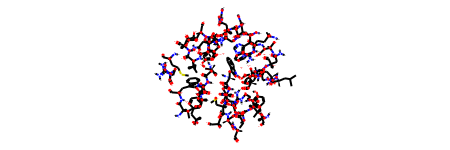

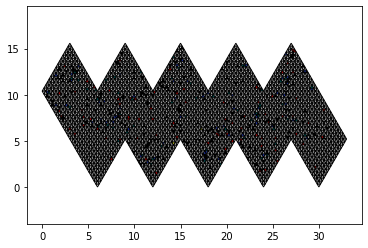

In [32]:
Create_PDBBind_Dataset(df_cluster = df_cluster_core, 
                df_index = df_index_core, 
                df_data = df_data_core, 
                DIVISION = 4, 
                save_dir = save_dir, 
                data_dir = data_dir, 
                out_filename = "PDBBind_TEST4.hdf5", 
                ico_key_name = "icosahedron_level4",
                PDB_or_mol2 = 'pdb',
                do_Hdonors = False,
                input_file_end_name='pocket',
                num_of_proteins_override= 5,
                NUM_MAPS_PER_MOLECULE=65,
                sanitize=False,
                SMILES_array=[],
                num_out_files=1,
                extra_augmentation='con-rotation',
                verbose=True)

Doing 5 molecules
Doing 5 extra maps using con-rotations
Doing conformers with random rotation
Got to Molecule no.  0
F:\Nextcloud\science\Datasets\pdbbind\v2015\1ps3\1ps3_ligand.mol2
1ps3
Finished the 60 standard unfoldings
Doing extra: face 13, direction 2
Doing extra: face 3, direction 2
Doing extra: face 1, direction 2
Doing extra: face 13, direction 2
Doing extra: face 0, direction 1
Finished the 5 con-rotation unfoldings
F:\Nextcloud\science\Datasets\pdbbind\v2015\3d4z\3d4z_ligand.mol2
3d4z
Finished the 60 standard unfoldings
Doing extra: face 1, direction 1
Doing extra: face 12, direction 2
Doing extra: face 11, direction 2
Doing extra: face 6, direction 1
Doing extra: face 19, direction 1
Finished the 5 con-rotation unfoldings
F:\Nextcloud\science\Datasets\pdbbind\v2015\3ejr\3ejr_ligand.mol2
3ejr
Finished the 60 standard unfoldings
Doing extra: face 14, direction 1
Doing extra: face 0, direction 2
Doing extra: face 9, direction 2
Doing extra: face 7, direction 2
Doing extra: fa

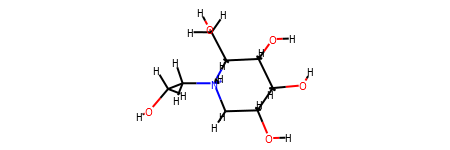

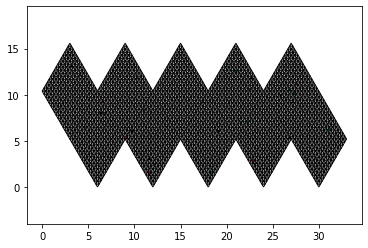

In [33]:
Create_PDBBind_Dataset(df_cluster = df_cluster_core, 
                df_index = df_index_core, 
                df_data = df_data_core, 
                DIVISION = 4, 
                save_dir = save_dir, 
                data_dir = data_dir, 
                out_filename = "PDBBind_ligand_TEST.hdf5", 
                ico_key_name = "icosahedron_level4",
                PDB_or_mol2 = 'mol2',
                do_Hdonors = False,
                input_file_end_name='ligand',
                num_of_proteins_override= 5,
                NUM_MAPS_PER_MOLECULE=65,
                sanitize=False,
                SMILES_array=[],
                extra_augmentation='con-rotation',
                verbose=True)

#### TESTS the test hdf5 file

In [34]:
#tests your h5 file

save_dir=save_dir
outfile = "PDBBind_TEST4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()

save_dir=save_dir
outfile = "PDBBind_ligand_TEST.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()



[5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356 

C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()


In [71]:
60*5 + 5*5

325

### Make the actual dataset
Assuming the tests above worked, you can make your datasets.

It will take time. Come back tomorrow.

The next step after you've made them is the run the normalisation script on them.

### Proteins Core Dataset (augmented)

Doing 195 molecules
Doing conformers with random rotation
Got to Molecule no.  0
1ps3
3d4z
3ejr
2qmj
3l4w
3l4u
3l7b
3g2n
3ebp
2w66
2wca
2vvn
2x97
2xhm
2x8z
2x0y
2cbj
2j62
3bkk
3l3n
2xy9
1gpk
1h23
1e66
3cj2
2d3u
3gnw
3f3a
3f3c
3f3e
4gqq
1u33
1xd0
2wbg
2j78
2cet
2zxd
2zwz
2zx6
3udh
4djv
4gid
3fk1
2qft
2pq9
1f8d
1f8b
1f8c
1n2v
1r5y
Got to Molecule no.  50
3ge7
3huc
3gcs
3e93
1q8t
1q8u
3ag9
3owj
2zjw
3pe2
2v00
3pww
3uri
3mfv
3f80
3kv2
2hb1
2qbr
2qbp
3fcq
1os0
4tmn
3pxf
2xnb
2fvd
1qi0
1w3k
1w3l
3imc
3ivg
3coy
3b3s
3b3w
3vh9
3mss
3k5v
2v7a
2brb
3jvs
1nvq
3acw
2zcr
2zcq
1bcu
1oyt
3utu
3u9q
2yfe
2p4y
3uo4
Got to Molecule no.  100
2wtv
3myg
3kgp
1o5b
1sqa
3kwa
2weg
3dd0
2xdl
1yc1
2yki
1p1q
3bfu
4g8m
3g2z
4de2
4de1
1vso
3gbb
3fv1
2y5h
2xbv
1mq6
1loq
1lol
1lor
1uto
3gy4
1o3f
2yge
2iwx
2vw5
2ymd
2xys
2x00
2r23
3bpc
1kel
3ozt
3oe5
3nw9
1zea
2pcp
1igj
1lbk
2gss
10gs
3su5
3su2
3su3
Got to Molecule no.  150
3n7a
3n86
2xb8
3ao4
3zsx
3zso
3nq3
3ueu
3uex
3lka
3ehy
3f17
3cft
4des
4dew
3dxg
1w4o
1u1b
3ov1


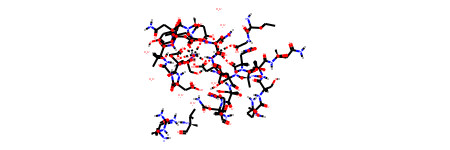

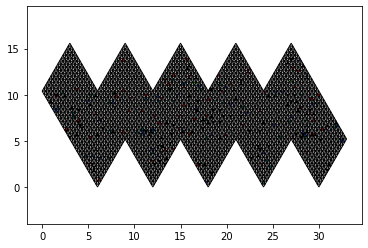

In [40]:
Create_PDBBind_Dataset(df_cluster = df_cluster_core, 
                df_index = df_index_core, 
                df_data = df_data_core, 
                DIVISION = 4, 
                save_dir = save_dir, 
                data_dir = data_dir, 
                out_filename = "2021_PDBBind_core_augmented_div4.hdf5", 
                ico_key_name = "icosahedron_level4",
                PDB_or_mol2 = 'pdb',
                do_Hdonors = False,
                input_file_end_name='pocket',
                num_of_proteins_override=0,
                NUM_MAPS_PER_MOLECULE=120,
                sanitize=False,
                SMILES_array=[],
                num_out_files=1,
                extra_augmentation='con-rotation',
                verbose=False)

In [15]:
#save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
outfile = "2021_PDBBindLigands_core_augmented_div4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
print(hf.keys())
hf.close()

[232.06953 232.06953 232.06953 ... 178.08412 178.08412 178.08412]
23400
<KeysViewHDF5 ['-logKd_over_Ki', 'EC_number', 'Kd_over_Ki', 'MolLogP', 'PDB_code', 'PMI_1', 'PMI_2', 'PMI_3', 'asphericity', 'eccentricity', 'icosahedron_level4', 'inertial_shape_factor', 'ligand_name', 'molID', 'num_ heteroatoms', 'num_H_acceptors', 'num_H_donors', 'num_atoms', 'num_bonds', 'num_exact_Mol_Wt', 'num_heavy_atoms', 'num_valence_electrons', 'protein_name', 'radius_of_gyration', 'reference', 'release_year', 'resolution', 'spherocity']>


C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """


### Ligands Core Dataset (augmented)

Doing 195 molecules
Doing conformers with random rotation
Got to Molecule no.  0
1ps3
3d4z
3ejr
2qmj
3l4w
3l4u
3l7b
3g2n
3ebp
2w66
2wca
2vvn
2x97
2xhm
2x8z
2x0y
2cbj
2j62
3bkk
3l3n
2xy9
1gpk
1h23
1e66
3cj2
2d3u
3gnw
3f3a
3f3c
3f3e
4gqq
1u33
1xd0
2wbg
2j78
2cet
2zxd
2zwz
2zx6
3udh
4djv
4gid
3fk1
2qft
2pq9
1f8d
1f8b
1f8c
1n2v
1r5y
Got to Molecule no.  50
3ge7
3huc
3gcs
3e93
1q8t
1q8u
3ag9
3owj
2zjw
3pe2
2v00
3pww
3uri
3mfv
3f80
3kv2
2hb1
2qbr
2qbp
3fcq
1os0
4tmn
3pxf
2xnb
2fvd
1qi0
1w3k
1w3l
3imc
3ivg
3coy
3b3s
3b3w
3vh9
3mss
3k5v
2v7a
2brb
3jvs
1nvq
3acw
2zcr
2zcq
1bcu
1oyt
3utu
3u9q
2yfe
2p4y
3uo4
Got to Molecule no.  100
2wtv
3myg
3kgp
1o5b
1sqa
3kwa
2weg
3dd0
2xdl
1yc1
2yki
1p1q
3bfu
4g8m
3g2z
4de2
4de1
1vso
3gbb
3fv1
2y5h
2xbv
1mq6
1loq
1lol
1lor
1uto
3gy4
1o3f
2yge
2iwx
2vw5
2ymd
2xys
2x00
2r23
3bpc
1kel
3ozt
3oe5
3nw9
1zea
2pcp
1igj
1lbk
2gss
10gs
3su5
3su2
3su3
Got to Molecule no.  150
3n7a
3n86
2xb8
3ao4
3zsx
3zso
3nq3
3ueu
3uex
3lka
3ehy
3f17
3cft
4des
4dew
3dxg
1w4o
1u1b
3ov1


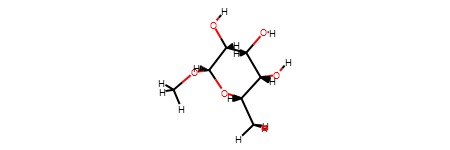

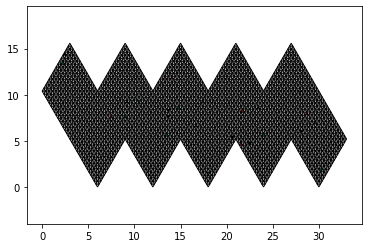

In [41]:
Create_PDBBind_Dataset(df_cluster = df_cluster_core, 
                df_index = df_index_core, 
                df_data = df_data_core, 
                DIVISION = 4, 
                save_dir = save_dir, 
                data_dir = data_dir, 
                out_filename = "2021_PDBBindLigand_core_augmented_div4.hdf5", 
                ico_key_name = "icosahedron_level4",
                PDB_or_mol2 = 'mol2',
                do_Hdonors = True,
                input_file_end_name='ligand',
                num_of_proteins_override=0,
                NUM_MAPS_PER_MOLECULE=120,
                sanitize=False,
                SMILES_array=[],
                num_out_files=1,
                extra_augmentation='con-rotation',
                verbose=False)

### Protein Restricted Dataset (augmented)

In [37]:
df_index_refined

,PDB_code,release_year,EC_number,protein_name
0,1i1e,2001,E.C.3.4.24.69,BOTULINUM_NEUROTOXIN_TYPE_B
1,1bxr,1999,E.C.6.3.5.5,CARBAMOYL-PHOSPHATE_SYNTHASE
2,3i3b,2010,E.C.3.2.1.23,BETA-GALACTOSIDASE
3,3dyo,2008,E.C.3.2.1.23,BETA-GALACTOSIDASE
4,3t0d,2012,E.C.3.2.1.23,BETA-GALACTOSIDASE
...,...,...,...,...
3701,2cc7,2006,E.C.-.-.-.-,"DODECIN,_VNG1446H"
3702,2vpe,2008,E.C.-.-.-.-,PYGOPUS_HOMOLOG_1
3703,3v2n,2013,E.C.-.-.-.-,CARTILAGE_OLIGOMERIZATION_MATRIX_PROTEIN_
3704,3v2q,2013,E.C.-.-.-.-,CARTILAGE_OLIGOMERIZATION_MATRIX_PROTEIN_


Doing 3706 molecules
Doing conformers with random rotation
Got to Molecule no.  0
1i1e
1bxr
3i3b
3dyo
3t0d
3vdb
3t08
1px4
3muz
3t2q
3t09
3mv0
3vd9
3t0b
3vd4
1ps3
3d52
3dx1
3d51
3ddf
3d50
3d4z
3d4y
3ddg
3dx3
2f7p
3dx2
3dx4
2f7o
3ejp
3ejr
3ejq
3w5n
2x09
2vzr
3w37
4ou3
4fys
4k5p
4r5t
3q44
3ebh
3t8v
3ebi
3lpp
2vc9
2zxg
3rsr
4kxb
4kx8
Got to Molecule no.  50
3lq2
3lpl
2qta
1rp7
1uho
3l4w
3ctt
3l4z
3l4v
3l4x
3l4y
3l4u
1kc7
4cu8
4cu7
2vo5
2vjx
2vmf
2vqt
2vl4
2vot
3l7d
3l7b
3l7c
3l79
4eky
2pyi
3g2h
3g2l
2qrm
3g2n
3l7a
4el0
3sym
2qrh
3ebo
3g2j
3g2k
3g2i
3syr
2qrq
2qrg
4el5
1a8i
3ebp
2qrp
2g9q
3qfz
3qfy
4iie
Got to Molecule no.  100
4iic
4iif
4iid
1jzs
4b9z
3hu3
4ko8
1yqy
4dv8
2f2h
1n1m
2ole
4lko
3sww
2oag
3nox
4jh0
1ez9
2pnc
2wzs
2wvz
4oc0
4oc1
4oc5
4ngn
3sjf
4ngp
3iww
4oc2
4oc3
2xej
3rbu
2xef
4ngm
2xei
2xeg
2jkp
2jke
2zq0
2w66
2jiw
2xm2
2w4x
2w67
2xm1
2j47
2wca
2j4g
2xj7
2vvn
Got to Molecule no.  150
2vvs
3hig
2aj8
3t6b
1h2t
3ff3
3fee
3fed
2vw2
2vw1
1r1j
1r1h
3lvw
1dar
4b76
4b73
4b74
1tkb
3d2e

3utu
1sl3
1pa9
3r5t
3zqe
3p3g
3ps1
4gu9
4kao
4k9y
4gu6
3dzt
3zll
4arw
4asj
2q7y
3g08
4gfo
3nyx
4jpy
3tk2
4jpx
4k77
4e5w
Got to Molecule no.  1500
4ehz
4ivb
4ei4
4e4l
4i5c
4e4n
4ivd
4fk6
4ivc
2pfy
2qpq
3wqm
3b3s
3b3c
3b3w
1ft7
3b7i
3vh9
1igb
1txr
2e2p
2pv1
2ves
4lch
1u1w
2rin
2reg
3mss
3ms9
3k5v
3pyy
2v7a
3tb6
1kmy
1lgt
1szd
2csn
4nl1
4d8z
4db7
4daf
4o0x
4app
4o0y
2x4z
3acl
3adv
3u9q
2i4z
2i4j
Got to Molecule no.  1550
4a4v
2yfe
4a4w
3fur
3b1m
1fm9
2p4y
3nht
3nhi
1m1b
3c2f
3c2r
3c2o
3g3r
1ctt
1ctu
2uy3
2uy4
2uy5
3m8t
2oax
1f73
1f74
3acw
3acx
4e9u
4ea2
3tfp
3tfn
2zcr
2zy1
3vje
2zcs
2zcq
1y1z
1pb9
1pb8
1y20
1pbq
2o4r
1rjk
2o4j
1xt8
2oi2
2rcb
3gvu
2wuf
4pmm
3hf8
3hfb
Got to Molecule no.  1600
1ugp
1gwv
1o7o
1lvu
1vfn
1a9q
1v48
3fuc
1b8n
1b8o
1hnn
2g72
2g71
2g70
2obf
1rpj
3kmc
3ewj
2oi0
3l0v
3b92
3le9
3lea
3c8e
2ews
3a1e
3a1c
3a1d
4fcf
4m0z
3qgw
4m12
4m0y
4m13
4m14
3miy
3qgy
4c2v
4fz3
1phw
1g7v
2a5s
3r6u
1k27
2bvd
2wzm
2yln
3ipu
3ipq
1i2s
Got to Molecule no.  1650
3b3x
4n5d
4nbk
4nbn
4n7m
4

2glp
3b7j
3ed0
3umq
3usx
3ng4
3uil
3nw3
4fnn
3o4k
3rt4
4b0b
4bkt
4bks
4w9c
4w9d
4w9l
4w9f
4w9i
4b9k
4w9j
4w9k
4w9h
1b55
1cgl
966c
2nsl
2nsj
2ate
4lxd
4ieh
4lvt
4kax
3gpo
4k7i
4k7n
4mmm
4k7o
2xp7
3ikd
3ikg
Got to Molecule no.  3000
2gl0
3afk
3m3o
3m3c
3m3e
3qyy
4jal
4rdn
3lka
2hu6
3ehy
3lir
3tsk
3f19
3f1a
3f18
3n2v
3ehx
3lk8
3ljg
4gr3
4gr8
3n2u
1rmz
3nx7
3f15
3f16
4efs
3f17
3ts4
4gr0
4gql
2ra6
4elf
4elh
4elg
3q7q
4in9
1jaq
1jao
1zs0
3tt4
1zvx
3elc
2amt
2gzl
1uwf
4att
4av4
4av5
Got to Molecule no.  3050
4avh
4avj
4avi
4auj
4lov
4buq
2r0h
1lrh
3tay
3nq3
3nq9
4gny
3ueu
3uev
3uew
1gx8
3uex
2gj5
4kow
4f7v
1ex8
4q0k
2p3i
4ad6
3qbc
2c92
2c97
2c94
1dhj
1dhi
2drc
1g85
1kyv
1str
1srg
2izl
1sld
1swr
1df8
2d0k
2qx0
2w9h
4c9x
1h0a
4c5d
4c52
3zlr
3e85
1dzk
1gu1
Got to Molecule no.  3100
1v1j
2fqt
2fqo
3alt
3brn
4fht
4mr6
1ws1
1s5z
4psb
1adl
2ans
3hk1
1g74
2qm9
3v3l
4qpl
3ap4
2yek
2ydw
4uyf
3rdq
3rdo
4lyw
4lzr
4lzs
3u5j
4cfl
4mr3
4nuc
3u5l
4wiv
4ogj
4nue
3zyu
2yel
3p5o
1dud
1s89
1egh
1ik4
1ucn
4jv8
4j

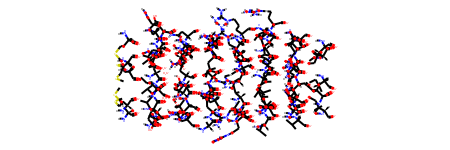

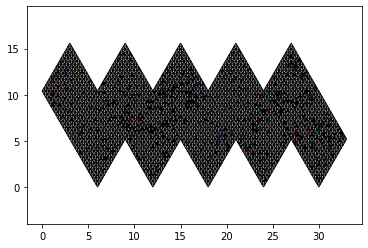

In [42]:
Create_PDBBind_Dataset(df_cluster = '', 
                df_index = df_index_refined, 
                df_data = df_data_refined, 
                DIVISION = 4, 
                save_dir = save_dir, 
                data_dir = data_dir, 
                out_filename = "2021_PDBBind_refined_augmented_div4.hdf5", 
                ico_key_name = "icosahedron_level4",
                PDB_or_mol2 = 'pdb',
                do_Hdonors = False,
                input_file_end_name='pocket',
                num_of_proteins_override=0,
                NUM_MAPS_PER_MOLECULE=120,
                sanitize=False,
                SMILES_array=[],
                num_out_files=1,
                extra_augmentation='con-rotation',
                do_cluster=False,
                verbose=False)

### Ligands Restricted Dataset (augmented)

Doing 3706 molecules
Doing conformers with random rotation
Got to Molecule no.  0
1i1e
1bxr
3i3b
3dyo
3t0d
3vdb
3t08
1px4
3muz
3t2q
3t09
3mv0
3vd9
3t0b
3vd4
1ps3
3d52
3dx1
3d51
3ddf
3d50
3d4z
3d4y
3ddg
3dx3
2f7p
3dx2
3dx4
2f7o
3ejp
3ejr
3ejq
3w5n
2x09
2vzr
3w37
4ou3
4fys
4k5p
4r5t
3q44
3ebh
3t8v
3ebi
3lpp
2vc9
2zxg
3rsr
4kxb
4kx8
Got to Molecule no.  50
3lq2
3lpl
2qta
1rp7
1uho
3l4w
3ctt
3l4z
3l4v
3l4x
3l4y
3l4u
1kc7
4cu8
4cu7
2vo5
2vjx
2vmf
2vqt
2vl4
2vot
3l7d
3l7b
3l7c
3l79
4eky
2pyi
3g2h
3g2l
2qrm
3g2n
3l7a
4el0
3sym
2qrh
3ebo
3g2j
3g2k
3g2i
3syr
2qrq
2qrg
4el5
1a8i
3ebp
2qrp
2g9q
3qfz
3qfy
4iie
Got to Molecule no.  100
4iic
4iif
4iid
1jzs
4b9z
3hu3
4ko8
1yqy
4dv8
2f2h
1n1m
2ole
4lko
3sww
2oag
3nox
4jh0
1ez9
2pnc
2wzs
2wvz
4oc0
4oc1
4oc5
4ngn
3sjf
4ngp
3iww
4oc2
4oc3
2xej
3rbu
2xef
4ngm
2xei
2xeg
2jkp
2jke
2zq0
2w66
2jiw
2xm2
2w4x
2w67
2xm1
2j47
2wca
2j4g
2xj7
2vvn
Got to Molecule no.  150
2vvs
3hig
2aj8
3t6b
1h2t
3ff3
3fee
3fed
2vw2
2vw1
1r1j
1r1h
3lvw
1dar
4b76
4b73
4b74
1tkb
3d2e

3utu
1sl3
1pa9
3r5t
3zqe
3p3g
3ps1
4gu9
4kao
4k9y
4gu6
3dzt
3zll
4arw
4asj
2q7y
3g08
4gfo
3nyx
4jpy
3tk2
4jpx
4k77
4e5w
Got to Molecule no.  1500
4ehz
4ivb
4ei4
4e4l
4i5c
4e4n
4ivd
4fk6
4ivc
2pfy
2qpq
3wqm
3b3s
3b3c
3b3w
1ft7
3b7i
3vh9
1igb
1txr
2e2p
2pv1
2ves
4lch
1u1w
2rin
2reg
3mss
3ms9
3k5v
3pyy
2v7a
3tb6
1kmy
1lgt
1szd
2csn
4nl1
4d8z
4db7
4daf
4o0x
4app
4o0y
2x4z
3acl
3adv
3u9q
2i4z
2i4j
Got to Molecule no.  1550
4a4v
2yfe
4a4w
3fur
3b1m
1fm9
2p4y
3nht
3nhi
1m1b
3c2f
3c2r
3c2o
3g3r
1ctt
1ctu
2uy3
2uy4
2uy5
3m8t
2oax
1f73
1f74
3acw
3acx
4e9u
4ea2
3tfp
3tfn
2zcr
2zy1
3vje
2zcs
2zcq
1y1z
1pb9
1pb8
1y20
1pbq
2o4r
1rjk
2o4j
1xt8
2oi2
2rcb
3gvu
2wuf
4pmm
3hf8
3hfb
Got to Molecule no.  1600
1ugp
1gwv
1o7o
1lvu
1vfn
1a9q
1v48
3fuc
1b8n
1b8o
1hnn
2g72
2g71
2g70
2obf
1rpj
3kmc
3ewj
2oi0
3l0v
3b92
3le9
3lea
3c8e
2ews
3a1e
3a1c
3a1d
4fcf
4m0z
3qgw
4m12
4m0y
4m13
4m14
3miy
3qgy
4c2v
4fz3
1phw
1g7v
2a5s
3r6u
1k27
2bvd
2wzm
2yln
3ipu
3ipq
1i2s
Got to Molecule no.  1650
3b3x
4n5d
4nbk
4nbn
4n7m
4

2glp
3b7j
3ed0
3umq
3usx
3ng4
3uil
3nw3
4fnn
3o4k
3rt4
4b0b
4bkt
4bks
4w9c
4w9d
4w9l
4w9f
4w9i
4b9k
4w9j
4w9k
4w9h
1b55
1cgl
966c
2nsl
2nsj
2ate
4lxd
4ieh
4lvt
4kax
3gpo
4k7i
4k7n
4mmm
4k7o
2xp7
3ikd
3ikg
Got to Molecule no.  3000
2gl0
3afk
3m3o
3m3c
3m3e
3qyy
4jal
4rdn
3lka
2hu6
3ehy
3lir
3tsk
3f19
3f1a
3f18
3n2v
3ehx
3lk8
3ljg
4gr3
4gr8
3n2u
1rmz
3nx7
3f15
3f16
4efs
3f17
3ts4
4gr0
4gql
2ra6
4elf
4elh
4elg
3q7q
4in9
1jaq
1jao
1zs0
3tt4
1zvx
3elc
2amt
2gzl
1uwf
4att
4av4
4av5
Got to Molecule no.  3050
4avh
4avj
4avi
4auj
4lov
4buq
2r0h
1lrh
3tay
3nq3
3nq9
4gny
3ueu
3uev
3uew
1gx8
3uex
2gj5
4kow
4f7v
1ex8
4q0k
2p3i
4ad6
3qbc
2c92
2c97
2c94
1dhj
1dhi
2drc
1g85
1kyv
1str
1srg
2izl
1sld
1swr
1df8
2d0k
2qx0
2w9h
4c9x
1h0a
4c5d
4c52
3zlr
3e85
1dzk
1gu1
Got to Molecule no.  3100
1v1j
2fqt
2fqo
3alt
3brn
4fht
4mr6
1ws1
1s5z
4psb
1adl
2ans
3hk1
1g74
2qm9
3v3l
4qpl
3ap4
2yek
2ydw
4uyf
3rdq
3rdo
4lyw
4lzr
4lzs
3u5j
4cfl
4mr3
4nuc
3u5l
4wiv
4ogj
4nue
3zyu
2yel
3p5o
1dud
1s89
1egh
1ik4
1ucn
4jv8
4j

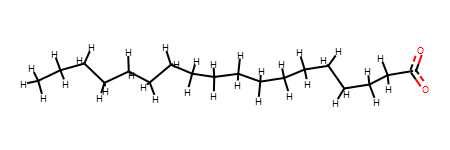

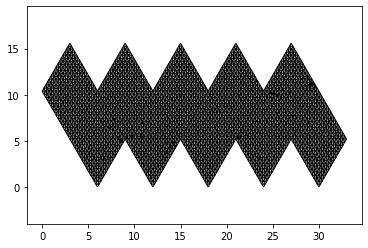

In [43]:
Create_PDBBind_Dataset(df_cluster = '', 
                df_index = df_index_refined, 
                df_data = df_data_refined, 
                DIVISION = 4, 
                save_dir = save_dir, 
                data_dir = data_dir, 
                out_filename = "2021_PDBBindLigands_refined_augmented_div4.hdf5", 
                ico_key_name = "icosahedron_level4",
                PDB_or_mol2 = 'mol2',
                do_Hdonors = True,
                input_file_end_name='ligand',
                num_of_proteins_override=0,
                NUM_MAPS_PER_MOLECULE=120,
                sanitize=False,
                SMILES_array=[],
                num_out_files=1,
                extra_augmentation='con-rotation',
                verbose=False)

## THIS WORKS and makes the hdf5 files for the ligands

In [47]:
# there is no overlap!
[x 
 for x in df_index_core['PDB_code'] if x in df_index_refined['PDB_code']]

[]

In [58]:
'1f8b' in df_index_core['PDB_code']

False

In [48]:
#tests your h5 file

save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
outfile = "PDBBindTEST_div4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()

save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
outfile = "PDBBindLigandTEST_div4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()

save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
outfile = "SMILESTEST_div4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()

[5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5388.494  5388.494  5388.494
 5388.494  5388.494  5388.494  5388.494  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356  5031.356  5031.356  5031.356  5031.356  5031.356
 5031.356  5031.356 

C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()
C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:25: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [209]:
random.choices([x for x in range(360)], k=3)

[299, 295, 94]

In [204]:
eggy[0]

array([ 0.35887196, -0.05005412, -0.26680223])

In [167]:
eggy=m.coords[:6]
eggy

array([[ 0.35887196, -0.05005412, -0.26680223],
       [ 0.31292442, -0.06735614, -0.20401122],
       [ 0.3232102 , -0.01671002, -0.14201487],
       [ 0.38333272,  0.00412227, -0.12579043],
       [ 0.32869089, -0.14631787, -0.17759856],
       [ 0.26338491,  0.00187626, -0.10741506]])

In [199]:
from scipy.spatial.transform import Rotation as R
verbose=True
Xx = 90
Yy = 45
Zz = 260

def rotation_with_quaternion(Xx, Yy, Zz, coords,verbose=False):
    """Xx : angle around x axis
    Yy: angle around y axis
    Zz: angle around z axis
    coords: matrix Nx3 of N atoms in 3 dimensions
    Quaternions are cool"""

    # makes a quaternion
    r = R.from_euler('zyx', 
    [Zz, Yy, Xx], degrees=True)
    if verbose:
        print(f'Quaternion is {r.as_quat()}')
    return r.apply(coords)

rotation_with_quaternion(Xx, Yy, Zz, coords=eggy,verbose=False)

array([[-0.26757867,  0.10973666, -0.34472808],
       [-0.22958542,  0.05893001, -0.29647413],
       [-0.15174221,  0.04909714, -0.31539825],
       [-0.13314525,  0.04474929, -0.37822486],
       [-0.26783092, -0.01666862, -0.29828951],
       [-0.10698781,  0.04492002, -0.25970931]])

In [200]:
r.apply(eggy)

array([[-0.26757867,  0.10973666, -0.34472808],
       [-0.22958542,  0.05893001, -0.29647413],
       [-0.15174221,  0.04909714, -0.31539825],
       [-0.13314525,  0.04474929, -0.37822486],
       [-0.26783092, -0.01666862, -0.29828951],
       [-0.10698781,  0.04492002, -0.25970931]])

In [180]:
eggy[0]

array([ 0.35887196, -0.05005412, -0.26680223])

In [163]:
rot_ar_x(2)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.41614684, -0.90929743,  0.        ],
       [ 0.        ,  0.90929743, -0.41614684,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [164]:
rot_ar_x(2) m.coords

ValueError: operands could not be broadcast together with shapes (4,4) (210,3) 

## Helper functions:
These were used to create the functions above and are not needed to create the datasets. Look at these if you're making your own datasets and like to avoid typing


In [160]:
## need to move this elsehwere
# this does rotations of hte coords from molecule 
# current rotations are not implemented

def rot_ar_x(radi):
    return  np.array([[1, 0, 0, 0],
                      [0, np.cos(radi), -np.sin(radi), 0],
                      [0, np.sin(radi), np.cos(radi), 0],
                     [0, 0, 0, 1]], dtype=np.double)
 
def rot_ar_y(radi):
    return  np.array([[np.cos(radi), 0, np.sin(radi), 0],
                      [0, 1, 0, 0],
                      [-np.sin(radi), 0, np.cos(radi), 0],
                     [0, 0, 0, 1]], dtype=np.double)
 
def rot_ar_z(radi):
    return  np.array([[np.cos(radi), -np.sin(radi), 0, 0],
                      [np.sin(radi), np.cos(radi), 0, 0],
                      [0, 0, 1, 0],
                     [0, 0, 0, 1]], dtype=np.double)
tforms = {0: rot_ar_x, 1: rot_ar_y, 2: rot_ar_z}

In [36]:
## These are helper functions use to reduce typing when making 
# the create dataset functions above
#### This writes out the commands we need, so we can copy and paste below
## there must be a better way of doing this!
def df_maker(column_list, verbose=True):    
    for header in column_list:
        # this makes the dfs
        cmd = "%s_ds = %s%s%s" % (
                slugify.slugify(header, separator="_"), 
                "outfile.create_dataset('",
                header, 
                "', (smile_count*NUM_MAPS_PER_MOLECULE,))")
        if verbose:
            print(cmd)
    return cmd

def df_writer(column_list,current_row):
    verbose=True
    for header in column_list:
        # this makes the dfs
        cmd1 = "%s = %s%s%s" % (
                slugify.slugify(header, separator="_"), 
                "current_row.iloc[0]['",
                header, 
                "']")
        cmd2 = "%s_ds[point_ptr] = %s" % (
                slugify.slugify(header, separator="_"),
                slugify.slugify(header, separator="_"))

        if verbose:
            print(cmd1)
            print(cmd2)
    return (cmd1, cmd2)
    
df_maker(column_list_name)
df_maker(column_list_data[3:])
df_maker([column_list_cluster[-1]])

for pro in range(1):
    # get the current PDB code
    current_code=df_index_core[["PDB_code"]].iloc[[pro]]
    current_code=current_code.iloc[0]['PDB_code']
    # get the rows in the dataframes
    current_index_row=df_index_core.loc[df_index_core['PDB_code']==current_code]
    #print(current_code)
    current_data_row=df_data_core.loc[df_data_core['PDB_code']==current_code]
    current_cluster_row=df_cluster_core.loc[df_cluster_core['PDB_code']==current_code]
    print(current_index_row)
    #print(current_data_row)
    #print(current_cluster_row)
    #current_row = current_index_row
    #column_list = column_list_name
    df_writer(column_list_name,current_index_row)
    df_writer(column_list_data[3:],current_data_row)
    df_writer([column_list_cluster[-1]],current_cluster_row)



pdb_code_ds = outfile.create_dataset('PDB_code', (smile_count*NUM_MAPS_PER_MOLECULE,))
release_year_ds = outfile.create_dataset('release_year', (smile_count*NUM_MAPS_PER_MOLECULE,))
ec_number_ds = outfile.create_dataset('EC_number', (smile_count*NUM_MAPS_PER_MOLECULE,))
protein_name_ds = outfile.create_dataset('protein_name', (smile_count*NUM_MAPS_PER_MOLECULE,))
logkd_ki_ds = outfile.create_dataset('-logKd/Ki', (smile_count*NUM_MAPS_PER_MOLECULE,))
kd_ki_ds = outfile.create_dataset('Kd/Ki', (smile_count*NUM_MAPS_PER_MOLECULE,))
reference_ds = outfile.create_dataset('reference', (smile_count*NUM_MAPS_PER_MOLECULE,))
ligand_name_ds = outfile.create_dataset('ligand name', (smile_count*NUM_MAPS_PER_MOLECULE,))
cluster_id_ds = outfile.create_dataset('cluster ID', (smile_count*NUM_MAPS_PER_MOLECULE,))
  PDB_code release_year      EC_number          protein_name
0     1ps3         2003  E.C.3.2.1.114  ALPHA-MANNOSIDASE_II
pdb_code = current_row.iloc[0]['PDB_code']
pdb_code_ds[point_ptr] = pd

In [118]:
# I think this has been updated elsewhere...
def Create_Dataset_From_SMILES(DIVISION, 
                   save_dir, 
                   data_dir, 
                   out_filename, 
                   do_Hdonors,
                   ico_key_name,
                   num_of_molecules_override=0,
                   NUM_MAPS_PER_MOLECULE=60,
                   sanitize=False,
                   SMILES_array=[],
                   verbose=False):
    """ Creates the dataset as a hdf5 file, expects DeepChem PDBBind organised files
    df_cluster = df_cluster_core = df of the cluster data (see the files that DeepChem downloads)
    df_index = df_index_core = df of index data
    df_data = df_data_core = df of the data 
    NUM_MAPS_PER_MOLECULE # how many maps to create
    DIVISION =4 # for the size of icospehre  
    save_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\converted_pdbbind\\v2015'
    data_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\pdbbind\\v2015'
    out_filename = "PDBBindLigands_core_augmented_withHs_withHdonors_div4.hdf5"
    ico_key_name_name = "icosahedron_level4"
    PDB_or_mol2 : 'pdb', 'mol2'
        :whether files are pdb or mol2 obviously
    input_file_end_name: 'ligand', 'protein', 'pocket'
        :whether files are binding pocket only or whole protein or ligand
    num_of_proteins_override : whether to do only a subset of the list
        : set to 0 to do the entire dataset, else set to how many you want
        : these are just the first ones, not shuffled
    do_Hdonors = True/False, whether to do the H donor data or not, don't do it for proteins
    sanitize = False: wehther to let DeepChem sanitize your molecule (NOT RECOMMENDED!)
    SMILES_array: array of smiles strings if you have them: notcurrently tested
    """
    
    outfile = h5py.File(os.path.join(save_dir,out_filename),"w")
    icosahedron_name = ico_key_name
    
    if num_of_molecules_override == 0:
        # do all proteins woo
        Num_of_molecules= len(SMILES_array)
    else:
        Num_of_molecules = num_of_molecules_override
        
    smiles_count = Num_of_molecules
    smile_count = Num_of_molecules # yeah i know, is hacky
    
    string_type = h5py.string_dtype(encoding='utf-8')

    if DIVISION == 1:
        NUM_FACES = 80
    elif DIVISION == 2:
        NUM_FACES = 320
    elif DIVISION == 3:
        NUM_FACES = 1280
    elif DIVISION == 4:
        NUM_FACES = 5120
        
    if NUM_MAPS_PER_MOLECULE == 1:
        NUM_UNWRAPPINGS_TO_DO = 1
        NUM_DIRECTIONS_TO_DO = 1
    elif NUM_MAPS_PER_MOLECULE == 60:
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
    else:
        # TODO implement this if you're going to use it!
        # or set the numbers by hand
        print('Error: Unimplemented! Can only do 1 or 60 maps per molecule!')
        pass    
    
    if sanitize:
        print('Warning! Sanitize seems to muck up the structures, especially for protiens')
        print('Think very carefully about if you want to do this, maybe do some testing in deepchem?')
    

    ## this sets up the output datasets
    icosahedron_ds =  outfile.create_dataset(icosahedron_name, (smile_count*NUM_MAPS_PER_MOLECULE, NUM_FACES, 3))  
    #charge_ds = outfile.create_dataset("charge", (smile_count*NUM_MAPS_PER_MOLECULE,))
    molID_ds = outfile.create_dataset("molID", (smile_count*NUM_MAPS_PER_MOLECULE,))
    if smiles_count > 0:
        smiles_ds = outfile.create_dataset('SMILES_strings', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    num_atoms_ds = outfile.create_dataset("num_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_bonds_ds = outfile.create_dataset("num_bonds", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heavy_atoms_ds = outfile.create_dataset("num_heavy_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_exact_Mol_Wt_ds = outfile.create_dataset("num_exact_Mol_Wt", (smile_count*NUM_MAPS_PER_MOLECULE,))
    MolLogP_ds = outfile.create_dataset("MolLogP", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    if do_Hdonors:
        num_H_acceptors_ds = outfile.create_dataset("num_H_acceptors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
        num_H_donors_ds = outfile.create_dataset("num_H_donors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heteroatoms_ds = outfile.create_dataset("num_ heteroatoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_valence_electrons_ds = outfile.create_dataset("num_valence_electrons", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_1_ds = outfile.create_dataset("PMI_1", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_2_ds = outfile.create_dataset("PMI_2", (smile_count*NUM_MAPS_PER_MOLECULE,))
    PMI_3_ds = outfile.create_dataset("PMI_3", (smile_count*NUM_MAPS_PER_MOLECULE,))
    spherocity_ds = outfile.create_dataset("spherocity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    asphericity_ds = outfile.create_dataset("asphericity", (smile_count*NUM_MAPS_PER_MOLECULE,))
    eccentricity_ds = outfile.create_dataset("eccentricity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    inertial_shape_factor_ds = outfile.create_dataset("inertial_shape_factor", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    radius_of_gyration_ds = outfile.create_dataset("radius_of_gyration", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    # copied from output of df_maker above sigh
    
    ## Das Loop
    point_ptr = -1                                               
    for mol_idx in range(Num_of_molecules): 
        if mol_idx % 50 == 0:
            print('Got to Molecule no. ', mol_idx)
        # finds the pdb file and reads in the molecule
        if verbose:
            print(file_location)

        m=Molecule(SMILES_array[mol_idx],sanitize=sanitize)
        tidy_m = m
        tidy_m.molecule.UpdatePropertyCache() # sigh we had to do this to get H donors!

        # puts the molecule into an icosasphere
        i = Ico(m,DIVISION)
        print(pdb_list[mol_idx])
        if smiles_count > 0:
            smiles_string = SMILES_array[mol_idx]
        for face_idx in range(NUM_UNWRAPPINGS_TO_DO): 
            for point_idx in range(NUM_DIRECTIONS_TO_DO): 
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### grab the atom values or colours or whatever
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                #### create the measurables you want to record
                values_as_array = np.array(values)
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)

                #### assign measurabless to columns
                icosahedron_ds[point_ptr] = values_as_array
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                if smiles_count > 0:
                    smiles_ds[point_ptr] = smiles_string
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 


    outfile.close()   
    i.draw2D()
    return
            


## Test of SMILES string list to hdf5 builder

In [115]:
SMILES_array=['N[C@@H](C)C(=O)O',
'N[C@H](C)C(=O)O',
'CCC(CC)O[C@@H]1C=C(C[C@@H]([C@H]1NC(=O)C)N)C(=O)OCC.OP(=O)(O)O']

In [117]:
Create_Dataset_From_SMILES(DIVISION=4, 
                    save_dir = save_dir, 
                    data_dir = data_dir, 
                    out_filename = "SMILESTEST_div4.hdf5", 
                    ico_key_name = "icosahedron_level4",
                    do_Hdonors=True,
                    num_of_molecules_override=0,
                    NUM_MAPS_PER_MOLECULE=60,
                    sanitize=True,
                    SMILES_array=SMILES_array,
                    verbose=False)

Warning! Sanitize seems to muck up the structures, especially for protiens
Think very carefully about if you want to do this, maybe do some testing in deepchem?
Got to Molecule no.  0


NameError: name 'pdb_list' is not defined

In [ ]:
save_dir=r'C:\Users\ella_\Nextcloud\science\Datasets\converted_pdbbind\v2015'
outfile = "SMILESTEST_div4.hdf5"
hf = h5py.File(os.path.join(save_dir,outfile), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
hf.keys()
hf.close()